In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 14.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sktime.clustering.k_means import TimeSeriesKMeans
import seaborn as sns
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Clustering

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Tải dữ liệu từ tệp CSV
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining 2/Time series code/imdb_ts_zscore_normalized.csv')
    print("Tải tệp thành công!")

    # Tách các cột chuỗi thời gian (từ '0' đến '99')
    time_series_columns = [str(i) for i in range(100)]
    X = df[time_series_columns].to_numpy()
    y_train = df['rating_category'].to_numpy()
    print(f"Kích thước của mảng chuỗi thời gian (X): {X.shape}")

except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp 'time-series-nomalize.csv'.")

Tải tệp thành công!
Kích thước của mảng chuỗi thời gian (X): (1134, 100)


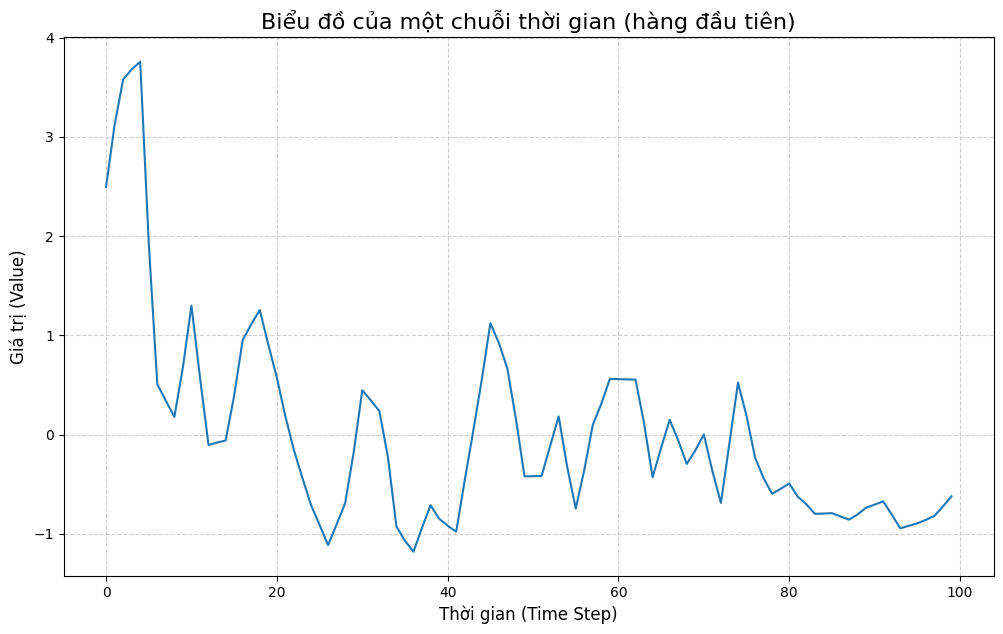

In [ ]:
# Đảm bảo bạn đã chạy Bước 1 trước
plt.figure(figsize=(12, 7))
plt.title("Biểu đồ của một chuỗi thời gian (hàng đầu tiên)", fontsize=16)
plt.plot(X[0])
plt.xlabel("Thời gian (Time Step)", fontsize=12)
plt.ylabel("Giá trị (Value)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('single_time_series.png')
plt.show()

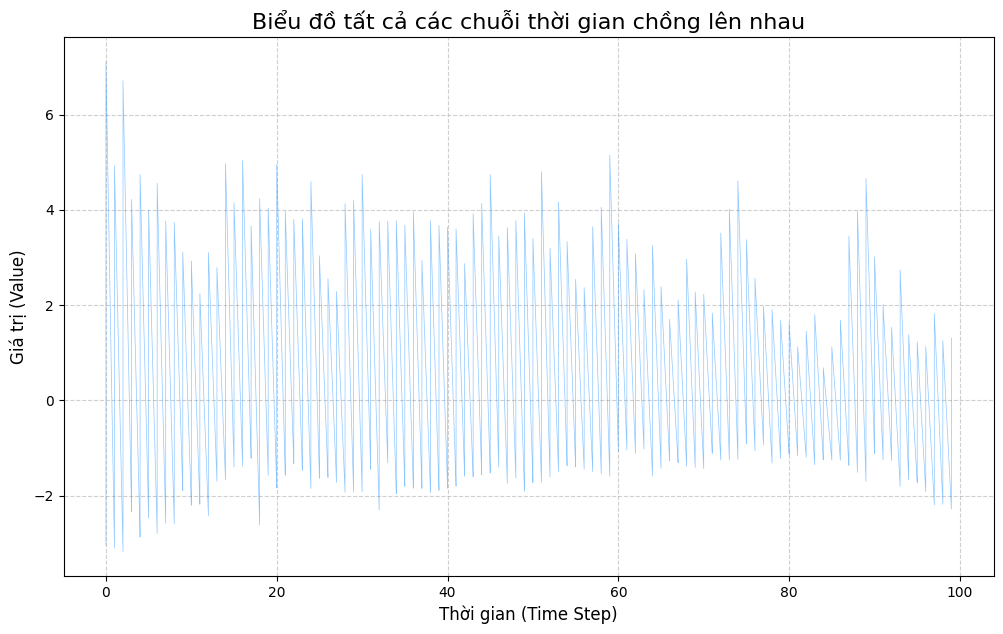

In [ ]:
# Đảm bảo bạn đã chạy Bước 1 trước
# Chuyển đổi mảng numpy thành DataFrame để "melt"
df_ts = pd.DataFrame(X)
df_melt = df_ts.melt(var_name="time", value_name="observation")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_melt, x="time", y="observation", estimator=None, lw=0.5, alpha=0.5, color='dodgerblue')
plt.title("Biểu đồ tất cả các chuỗi thời gian chồng lên nhau", fontsize=16)
plt.xlabel("Thời gian (Time Step)", fontsize=12)
plt.ylabel("Giá trị (Value)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('all_time_series.png')
plt.show()

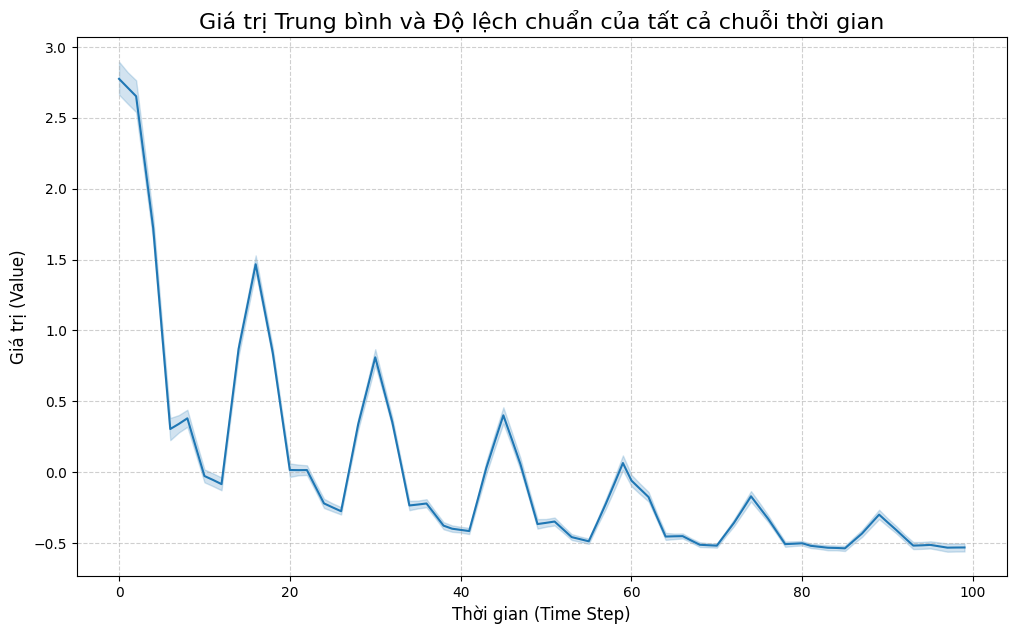

In [ ]:
# Đảm bảo bạn đã chạy Bước 3 trước
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_melt, x="time", y="observation") # estimator='mean' là mặc định
plt.title("Giá trị Trung bình và Độ lệch chuẩn của tất cả chuỗi thời gian", fontsize=16)
plt.xlabel("Thời gian (Time Step)", fontsize=12)
plt.ylabel("Giá trị (Value)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('mean_std_time_series.png')
plt.show()

# DBSCAN data gốc

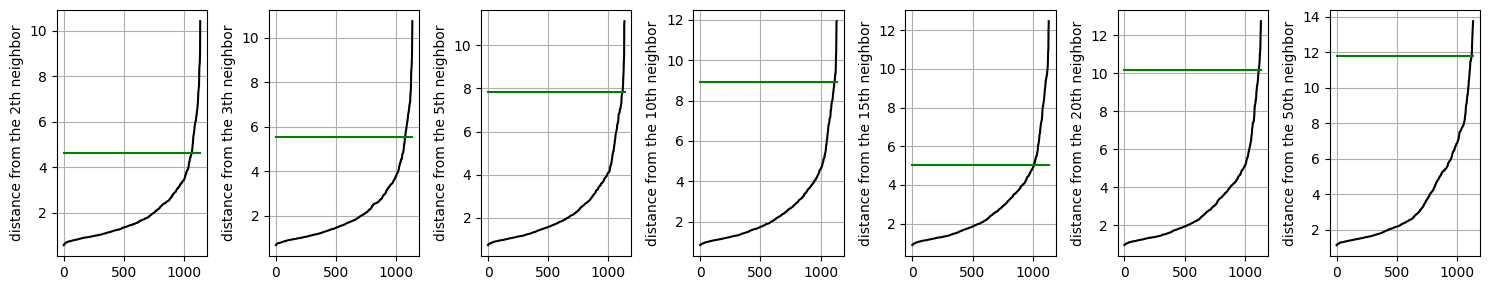

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

ks = [2, 3, 5, 10, 15, 20, 50]
X_eps = []


def eps_choice(df, ks, eps_list):
    dist = squareform(pdist(df, 'euclidean'))

    fig = plt.figure(figsize=(15, 3)) # dimensions of the overall plot
    fig_dims = (1, len(ks))

    for i in range(len(ks)):
        k = ks[i]
        kth_distances = []

        for d in dist:  # d is a vector containing distances between the ith record and all the others
            index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
            kth_distances.append(d[index_kth_distance])  # store the distance in a list

        # Sort the distances
        kth_distances.sort()

        # Create an array of indices
        indices = np.arange(len(kth_distances))

        # Use the KneeLocator to find the elbow point
        knee_locator = KneeLocator(indices, kth_distances, curve='convex', direction='increasing')
        elbow_point = knee_locator.knee
        eps_list.append(round(kth_distances[elbow_point], 2))  # Round to 2 decimal places

        plt.subplot2grid(fig_dims, (0, i))
        plt.plot(indices, kth_distances, 'black')
        plt.plot([0, len(kth_distances)], [kth_distances[elbow_point], kth_distances[elbow_point]], 'g-')  # Plot the elbow point
        plt.ylabel('distance from the {}th neighbor'.format(k))
        plt.grid(True)  # This line adds a grid to the plot

    plt.tight_layout()
    plt.show()

eps_choice(X, ks, X_eps)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
def dbscan_results(df, eps, ks):
  for i in range(len(eps)):
    db = DBSCAN(eps=eps[i], min_samples=ks[i]).fit(df)
    labels, counts = np.unique(db.labels_, return_counts=True)
    print(labels, counts)
    print(f"eps={eps[i]}, minPts={ks[i]} -> {len(labels)-1} clusters")
    for i in range(len(labels)):
      print(f"Cluster [{labels[i]}]: {counts[i]} samples")

    clustering_labels = db.fit_predict(df)
    #df.loc[:, 'db_labels'] = clustering_labels
    if len(np.unique(db.labels_)) > 2:
        print('Silhouette (F)', silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1]))
    else:
        print('Cannot calculate silhouette score with only one cluster')

    print("--------------------------------")

dbscan_results(df=X, eps=X_eps, ks=ks)

[-1  0  1  2  3  4  5  6] [  58 1054    4    6    2    4    4    2]
eps=4.62, minPts=2 -> 7 clusters
Cluster [-1]: 58 samples
Cluster [0]: 1054 samples
Cluster [1]: 4 samples
Cluster [2]: 6 samples
Cluster [3]: 2 samples
Cluster [4]: 4 samples
Cluster [5]: 4 samples
Cluster [6]: 2 samples
Silhouette (F) 0.39356738332640473
--------------------------------
[-1  0  1  2] [  40 1084    6    4]
eps=5.53, minPts=3 -> 3 clusters
Cluster [-1]: 40 samples
Cluster [0]: 1084 samples
Cluster [1]: 6 samples
Cluster [2]: 4 samples
Silhouette (F) 0.5070510057919657
--------------------------------
[-1  0] [   8 1126]
eps=7.82, minPts=5 -> 1 clusters
Cluster [-1]: 8 samples
Cluster [0]: 1126 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [   3 1131]
eps=8.92, minPts=10 -> 1 clusters
Cluster [-1]: 3 samples
Cluster [0]: 1131 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [  80 1054]
eps=

## eps=5.53, minPts=3 là lựa chọn cân bằng và hiệu quả nhất, mang lại kết quả phân cụm có ý nghĩa nhất với điểm số định lượng cao nhất.

In [ ]:
clusterer = DBSCAN(eps=5.53, min_samples=10)

In [ ]:
clusterer.fit(X)

DBSCAN(eps=5.53, min_samples=10)

In [ ]:
df["cluster"] = clusterer.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,0.674897,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,0
1,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,0.073705,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,-1
2,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,0.346184,...,-0.818806,-0.813383,-0.794138,-0.777756,-0.800588,-0.827329,8.7,"['Documentary', 'Music']",High,0
3,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,-0.575373,...,-0.555855,-0.611540,-0.612517,-0.613961,-0.615186,-0.616180,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,-1
4,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,1.226049,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,0


Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


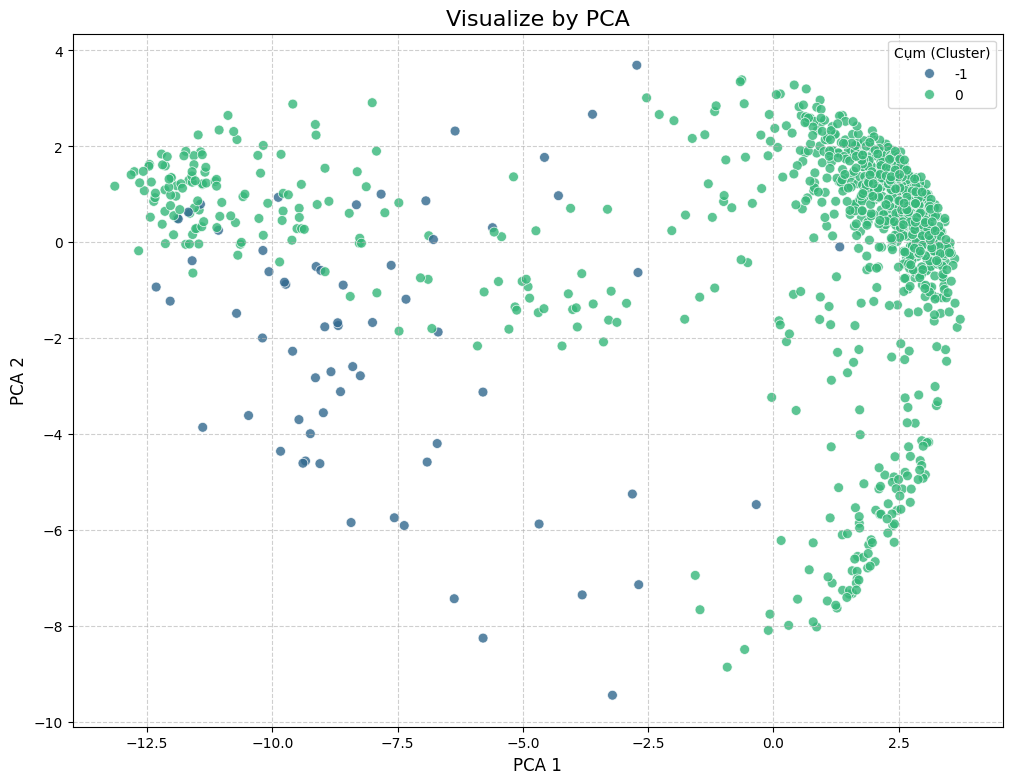

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) ---
# Kiểm tra xem các cột cần thiết có tồn tại không
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    # THAY ĐỔI CHÍNH Ở ĐÂY: Thêm các cột cần loại bỏ vào danh sách
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)

    # Lấy cột 'cluster' làm nhãn
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng PCA trên features (Không thay đổi) ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ (Không thay đổi) ---
    df_pca = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2'])
    df_pca['Cụm (Cluster)'] = labels

    # --- Bước 4: Vẽ biểu đồ Scatter Plot (Không thay đổi) ---
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="PCA 1",
        y="PCA 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_pca,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by PCA', fontsize=16)
    plt.xlabel('PCA 1', fontsize=12)
    plt.ylabel('PCA 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


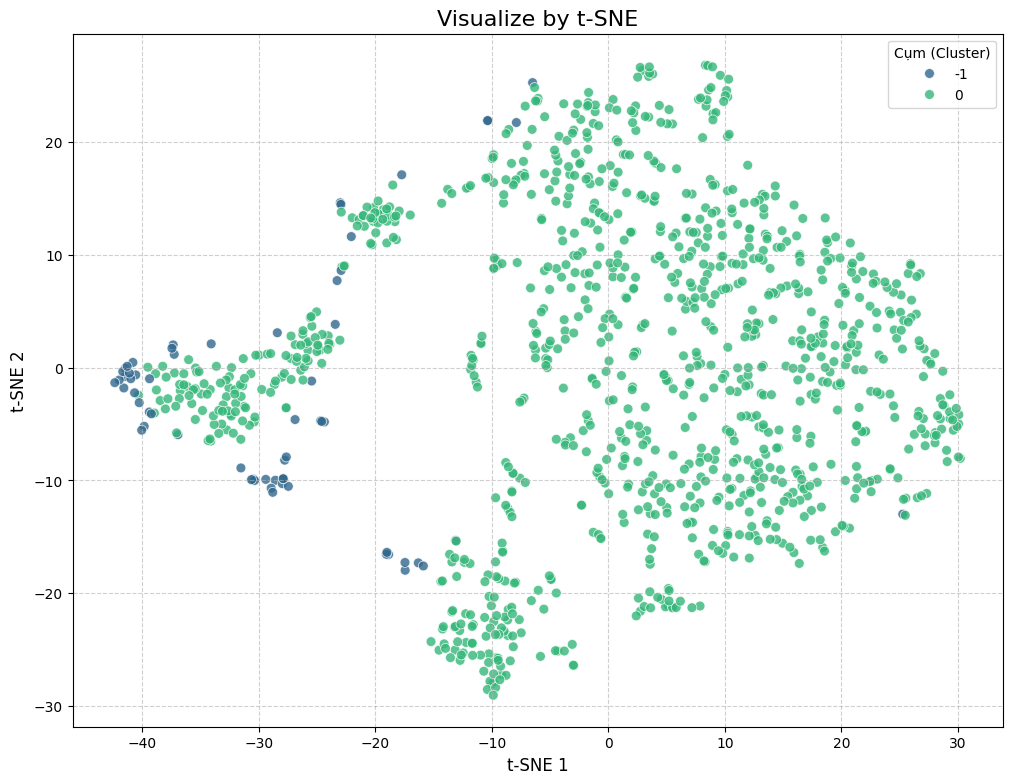

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) (Không thay đổi) ---
# Logic này giống hệt như với PCA
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng t-SNE trên features ---
    # THAY ĐỔI CHÍNH Ở ĐÂY: Sử dụng TSNE thay vì PCA
    # Lưu ý: t-SNE có thể chạy khá chậm trên dữ liệu lớn.
    # 'perplexity' là một tham số quan trọng cần tinh chỉnh.
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
    X_tsne = tsne.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ ---
    # Cập nhật tên cột để phản ánh rằng đây là dữ liệu t-SNE
    df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
    df_tsne['Cụm (Cluster)'] = labels
    # --- Bước 4: Vẽ biểu đồ Scatter Plot ---
    # Cập nhật các trục và tiêu đề cho phù hợp với t-SNE
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="t-SNE 1",
        y="t-SNE 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_tsne,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by t-SNE', fontsize=16)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Features-based Clustering

Custom Features Extraction

In [ ]:
import scipy.stats as stats

In [ ]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [ ]:
X.shape

(1134, 100)

In [ ]:
X[0]

array([ 2.48269134e+00,  3.10374680e+00,  3.55949756e+00,  3.66160403e+00,
        3.73801778e+00,  1.92269305e+00,  5.04129143e-01,  3.40079544e-01,
        1.76768242e-01,  6.74897245e-01,  1.29307335e+00,  5.72643107e-01,
       -1.04670584e-01, -7.99376339e-02, -5.95606360e-02,  3.90062253e-01,
        9.48288634e-01,  1.10606271e+00,  1.24855403e+00,  9.03031026e-01,
        5.71904810e-01,  1.82305470e-01, -1.55834568e-01, -4.36682757e-01,
       -7.05053726e-01, -9.05722857e-01, -1.10668731e+00, -9.01293075e-01,
       -6.85931833e-01, -1.75916247e-01,  4.43957936e-01,  3.44435497e-01,
        2.36274982e-01, -2.20730877e-01, -9.20784117e-01, -1.06386608e+00,
       -1.17402000e+00, -9.32227721e-01, -7.07342446e-01, -8.43336759e-01,
       -9.12810509e-01, -9.73498524e-01, -4.58093371e-01,  3.81898903e-02,
        5.51823131e-01,  1.11573440e+00,  9.18166115e-01,  6.59171519e-01,
        1.53881034e-01, -4.19332777e-01, -4.16748737e-01, -4.14533846e-01,
       -1.14416105e-01,  

In [ ]:
calculate_features(X[0])

{'avg': np.float64(8.326672684688674e-17),
 'std': np.float64(0.9949874371066201),
 'var': np.float64(0.9900000000000003),
 'med': np.float64(-0.19832356197835055),
 '10p': np.float64(-0.9017360533691604),
 '25p': np.float64(-0.7104802088193948),
 '50p': np.float64(-0.19832356197835055),
 '75p': np.float64(0.40353617350502724),
 '90p': np.float64(0.9640660414806052),
 'iqr': np.float64(1.114016382324422),
 'cov': np.float64(8.368620923398063e-17),
 'skw': np.float64(1.9130722276544958),
 'kur': np.float64(4.2518076086647065)}

In [ ]:
feature_values = [list(calculate_features(row).values()) for row in X]
index_values = list(range(0, X.shape[0]))
column_values = list(calculate_features(X[0]).keys())

CF_Train = pd.DataFrame(data = feature_values, index = index_values, columns = column_values)
CF_Train

,avg,std,var,med,10p,25p,50p,75p,90p,iqr,cov,skw,kur
0,8.326673e-17,0.994987,0.99,-0.198324,-0.901736,-0.710480,-0.198324,0.403536,0.964066,1.114016,8.368621e-17,1.913072,4.251808
1,-2.220446e-18,0.994987,0.99,-0.344959,-0.969934,-0.763264,-0.344959,0.527258,1.640171,1.290522,-2.231632e-18,1.193006,0.850890
2,-2.775558e-17,0.994987,0.99,-0.397235,-0.789556,-0.736270,-0.397235,0.453807,1.742394,1.190077,-2.789540e-17,1.557533,1.768344
3,1.110223e-17,0.994987,0.99,-0.411602,-0.611444,-0.593134,-0.411602,0.024334,1.207415,0.617468,1.115816e-17,2.356643,5.318109
4,3.663736e-17,0.994987,0.99,-0.494929,-0.662540,-0.639699,-0.494929,0.215622,1.465341,0.855321,3.682193e-17,1.793446,2.759181
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1.332268e-17,0.994987,0.99,-0.452917,-0.584285,-0.560754,-0.452917,0.113832,0.913059,0.674586,1.338979e-17,2.700850,7.437766
1130,7.105427e-17,0.994987,0.99,-0.630160,-0.754672,-0.718504,-0.630160,0.404634,1.466897,1.123139,7.141223e-17,1.513653,1.536342
1131,4.329870e-17,0.994987,0.99,-0.428689,-0.730295,-0.589850,-0.428689,0.336915,1.215311,0.926765,4.351683e-17,2.175392,4.906468
1132,-1.221245e-17,0.994987,0.99,-0.335559,-0.548772,-0.522190,-0.335559,-0.038274,0.815898,0.483915,-1.227398e-17,2.894677,8.117517


## DBSCAN

## Best parameter

In [ ]:
!pip install kneed

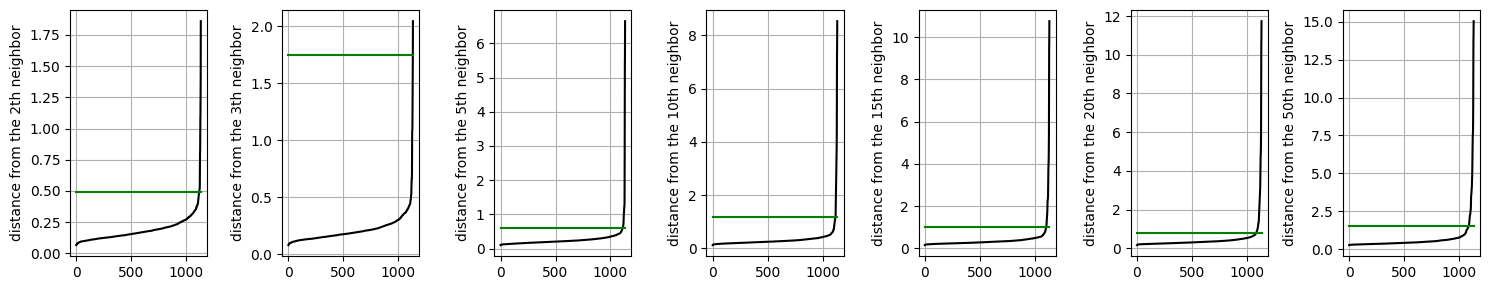

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

ks = [2, 3, 5, 10, 15, 20, 50]
X_eps = []


def eps_choice(df, ks, eps_list):
    dist = squareform(pdist(df, 'euclidean'))

    fig = plt.figure(figsize=(15, 3)) # dimensions of the overall plot
    fig_dims = (1, len(ks))

    for i in range(len(ks)):
        k = ks[i]
        kth_distances = []

        for d in dist:  # d is a vector containing distances between the ith record and all the others
            index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
            kth_distances.append(d[index_kth_distance])  # store the distance in a list

        # Sort the distances
        kth_distances.sort()

        # Create an array of indices
        indices = np.arange(len(kth_distances))

        # Use the KneeLocator to find the elbow point
        knee_locator = KneeLocator(indices, kth_distances, curve='convex', direction='increasing')
        elbow_point = knee_locator.knee
        eps_list.append(round(kth_distances[elbow_point], 2))  # Round to 2 decimal places

        plt.subplot2grid(fig_dims, (0, i))
        plt.plot(indices, kth_distances, 'black')
        plt.plot([0, len(kth_distances)], [kth_distances[elbow_point], kth_distances[elbow_point]], 'g-')  # Plot the elbow point
        plt.ylabel('distance from the {}th neighbor'.format(k))
        plt.grid(True)  # This line adds a grid to the plot

    plt.tight_layout()
    plt.show()

eps_choice(CF_Train, ks, X_eps)

In [ ]:
print(ks)
print(X_eps)

[2, 3, 5, 10, 15, 20, 50]
[np.float64(0.49), np.float64(1.75), np.float64(0.59), np.float64(1.17), np.float64(1.0), np.float64(0.78), np.float64(1.52)]


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
def dbscan_results(df, eps, ks):
  for i in range(len(eps)):
    db = DBSCAN(eps=eps[i], min_samples=ks[i]).fit(df)
    labels, counts = np.unique(db.labels_, return_counts=True)
    print(labels, counts)
    print(f"eps={eps[i]}, minPts={ks[i]} -> {len(labels)-1} clusters")
    for i in range(len(labels)):
      print(f"Cluster [{labels[i]}]: {counts[i]} samples")

    clustering_labels = db.fit_predict(df)
    #df.loc[:, 'db_labels'] = clustering_labels
    if len(np.unique(db.labels_)) > 2:
        print('Silhouette (F)', silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1]))
    else:
        print('Cannot calculate silhouette score with only one cluster')

    print("--------------------------------")

dbscan_results(df=CF_Train, eps=X_eps, ks=ks)

[-1  0  1  2  3  4  5] [  14 1103    2    8    2    2    3]
eps=0.49, minPts=2 -> 6 clusters
Cluster [-1]: 14 samples
Cluster [0]: 1103 samples
Cluster [1]: 2 samples
Cluster [2]: 8 samples
Cluster [3]: 2 samples
Cluster [4]: 2 samples
Cluster [5]: 3 samples
Silhouette (F) 0.5671130982681013
--------------------------------
[0 1] [1130    4]
eps=1.75, minPts=3 -> 1 clusters
Cluster [0]: 1130 samples
Cluster [1]: 4 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0  1  2] [  16 1107    8    3]
eps=0.59, minPts=5 -> 3 clusters
Cluster [-1]: 16 samples
Cluster [0]: 1107 samples
Cluster [1]: 8 samples
Cluster [2]: 3 samples
Silhouette (F) 0.5671836807068481
--------------------------------
[-1  0  1] [  15 1109   10]
eps=1.17, minPts=10 -> 2 clusters
Cluster [-1]: 15 samples
Cluster [0]: 1109 samples
Cluster [1]: 10 samples
Silhouette (F) 0.5794869503300536
--------------------------------
[-1  0] [  26 1108]
eps=1.0, minPts=15 -> 1 clus

lựa chọn tốt nhất là eps=1.17, minPts=10.

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
clusterer = DBSCAN(eps=1.17, min_samples=10)

In [ ]:
clusterer.fit(CF_Train)

DBSCAN(eps=1.17, min_samples=10)

In [ ]:
CF_Train["cluster"] = clusterer.labels_

In [ ]:
CF_Train

,avg,std,var,med,10p,25p,50p,75p,90p,iqr,cov,skw,kur,cluster
0,8.326673e-17,0.994987,0.99,-0.198324,-0.901736,-0.710480,-0.198324,0.403536,0.964066,1.114016,8.368621e-17,1.913072,4.251808,0
1,-2.220446e-18,0.994987,0.99,-0.344959,-0.969934,-0.763264,-0.344959,0.527258,1.640171,1.290522,-2.231632e-18,1.193006,0.850890,0
2,-2.775558e-17,0.994987,0.99,-0.397235,-0.789556,-0.736270,-0.397235,0.453807,1.742394,1.190077,-2.789540e-17,1.557533,1.768344,0
3,1.110223e-17,0.994987,0.99,-0.411602,-0.611444,-0.593134,-0.411602,0.024334,1.207415,0.617468,1.115816e-17,2.356643,5.318109,0
4,3.663736e-17,0.994987,0.99,-0.494929,-0.662540,-0.639699,-0.494929,0.215622,1.465341,0.855321,3.682193e-17,1.793446,2.759181,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1.332268e-17,0.994987,0.99,-0.452917,-0.584285,-0.560754,-0.452917,0.113832,0.913059,0.674586,1.338979e-17,2.700850,7.437766,0
1130,7.105427e-17,0.994987,0.99,-0.630160,-0.754672,-0.718504,-0.630160,0.404634,1.466897,1.123139,7.141223e-17,1.513653,1.536342,0
1131,4.329870e-17,0.994987,0.99,-0.428689,-0.730295,-0.589850,-0.428689,0.336915,1.215311,0.926765,4.351683e-17,2.175392,4.906468,0
1132,-1.221245e-17,0.994987,0.99,-0.335559,-0.548772,-0.522190,-0.335559,-0.038274,0.815898,0.483915,-1.227398e-17,2.894677,8.117517,0


In [ ]:
df["cluster"] = clusterer.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,0.674897,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,0
1,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,0.073705,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,0
2,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,0.346184,...,-0.818806,-0.813383,-0.794138,-0.777756,-0.800588,-0.827329,8.7,"['Documentary', 'Music']",High,0
3,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,-0.575373,...,-0.555855,-0.611540,-0.612517,-0.613961,-0.615186,-0.616180,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,0
4,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,1.226049,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,0


Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


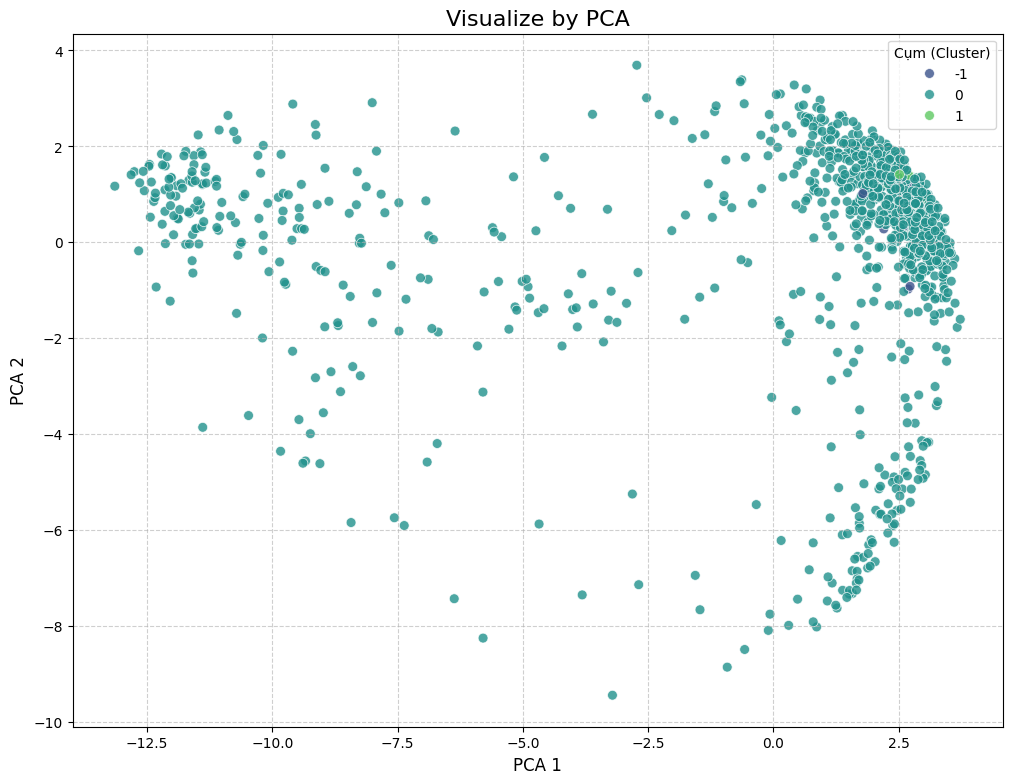

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) ---
# Kiểm tra xem các cột cần thiết có tồn tại không
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    # THAY ĐỔI CHÍNH Ở ĐÂY: Thêm các cột cần loại bỏ vào danh sách
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)

    # Lấy cột 'cluster' làm nhãn
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng PCA trên features (Không thay đổi) ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ (Không thay đổi) ---
    df_pca = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2'])
    df_pca['Cụm (Cluster)'] = labels

    # --- Bước 4: Vẽ biểu đồ Scatter Plot (Không thay đổi) ---
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="PCA 1",
        y="PCA 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_pca,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by PCA', fontsize=16)
    plt.xlabel('PCA 1', fontsize=12)
    plt.ylabel('PCA 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


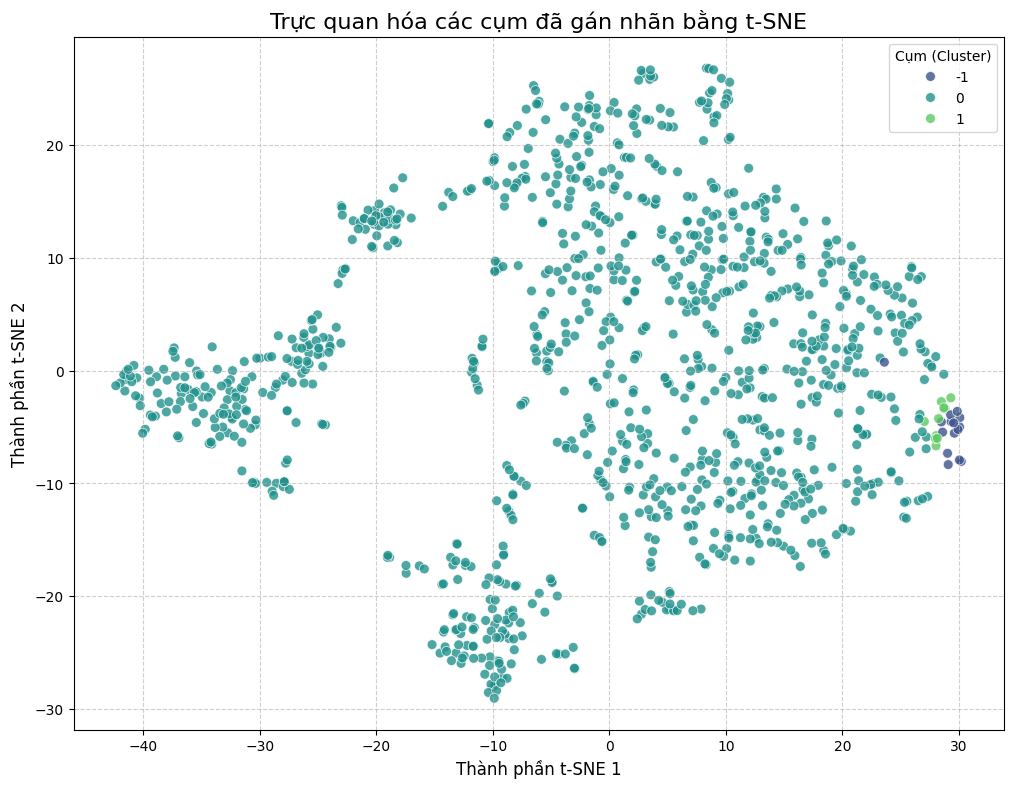

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) (Không thay đổi) ---
# Logic này giống hệt như với PCA
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng t-SNE trên features ---
    # THAY ĐỔI CHÍNH Ở ĐÂY: Sử dụng TSNE thay vì PCA
    # Lưu ý: t-SNE có thể chạy khá chậm trên dữ liệu lớn.
    # 'perplexity' là một tham số quan trọng cần tinh chỉnh.
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
    X_tsne = tsne.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ ---
    # Cập nhật tên cột để phản ánh rằng đây là dữ liệu t-SNE
    df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
    df_tsne['Cụm (Cluster)'] = labels
    # --- Bước 4: Vẽ biểu đồ Scatter Plot ---
    # Cập nhật các trục và tiêu đề cho phù hợp với t-SNE
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="t-SNE 1",
        y="t-SNE 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_tsne,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Trực quan hóa các cụm đã gán nhãn bằng t-SNE', fontsize=16)
    plt.xlabel('Thành phần t-SNE 1', fontsize=12)
    plt.ylabel('Thành phần t-SNE 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## KẾT QUẢ VẪN K TỐT, THỬ CÁCH CHỌN FEATURES KHÁC Ở DƯỚI

Summary Transformer Extractor

In [ ]:
from sktime.transformations.series.summarize import SummaryTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [8]:
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
print(f"Kích thước mới của X sau khi reshape (3D): {X_reshaped.shape}")

Kích thước mới của X sau khi reshape (3D): (1134, 1, 100)


In [ ]:
transformer = SummaryTransformer()

In [ ]:
F_train = transformer.fit_transform(X_reshaped)
F_train

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
instances,,,,,,,,,
0,8.326673e-17,1.0,-1.174020,3.738018,-0.901736,-0.710480,-0.198324,0.403536,0.964066
1,-2.220446e-18,1.0,-1.313210,3.434529,-0.969934,-0.763264,-0.344959,0.527258,1.640171
2,-2.775558e-17,1.0,-0.828687,3.132039,-0.789556,-0.736270,-0.397235,0.453807,1.742394
3,1.110223e-17,1.0,-0.616180,4.165186,-0.611444,-0.593134,-0.411602,0.024334,1.207415
4,3.663736e-17,1.0,-0.672808,4.115150,-0.662540,-0.639699,-0.494929,0.215622,1.465341
...,...,...,...,...,...,...,...,...,...
1129,1.332268e-17,1.0,-0.595935,4.128610,-0.584285,-0.560754,-0.452917,0.113832,0.913059
1130,7.105427e-17,1.0,-0.758623,3.024155,-0.754672,-0.718504,-0.630160,0.404634,1.466897
1131,4.329870e-17,1.0,-0.884430,4.070935,-0.730295,-0.589850,-0.428689,0.336915,1.215311


## Tìm tham số tốt nhất

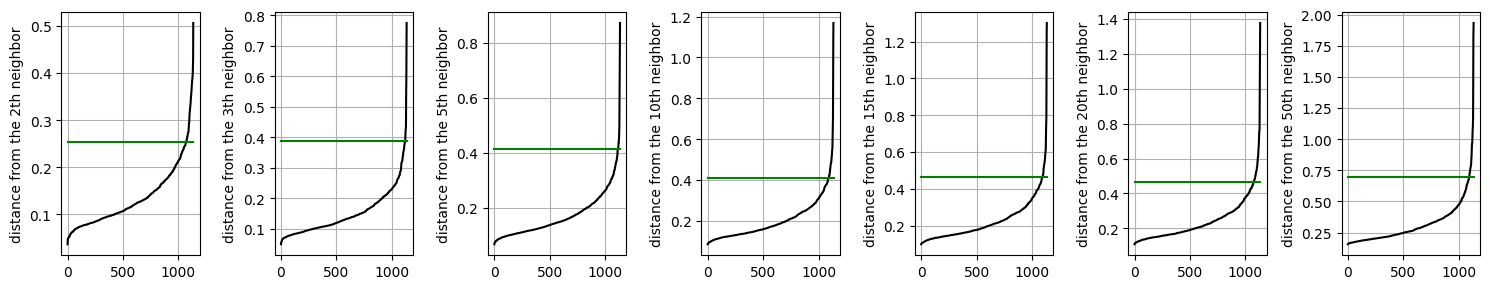

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

ks = [2, 3, 5, 10, 15, 20, 50]
X_eps = []


def eps_choice(df, ks, eps_list):
    dist = squareform(pdist(df, 'euclidean'))

    fig = plt.figure(figsize=(15, 3)) # dimensions of the overall plot
    fig_dims = (1, len(ks))

    for i in range(len(ks)):
        k = ks[i]
        kth_distances = []

        for d in dist:  # d is a vector containing distances between the ith record and all the others
            index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
            kth_distances.append(d[index_kth_distance])  # store the distance in a list

        # Sort the distances
        kth_distances.sort()

        # Create an array of indices
        indices = np.arange(len(kth_distances))

        # Use the KneeLocator to find the elbow point
        knee_locator = KneeLocator(indices, kth_distances, curve='convex', direction='increasing')
        elbow_point = knee_locator.knee
        eps_list.append(round(kth_distances[elbow_point], 2))  # Round to 2 decimal places

        plt.subplot2grid(fig_dims, (0, i))
        plt.plot(indices, kth_distances, 'black')
        plt.plot([0, len(kth_distances)], [kth_distances[elbow_point], kth_distances[elbow_point]], 'g-')  # Plot the elbow point
        plt.ylabel('distance from the {}th neighbor'.format(k))
        plt.grid(True)  # This line adds a grid to the plot

    plt.tight_layout()
    plt.show()

eps_choice(F_train, ks, X_eps)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
def dbscan_results(df, eps, ks):
  for i in range(len(eps)):
    db = DBSCAN(eps=eps[i], min_samples=ks[i]).fit(df)
    labels, counts = np.unique(db.labels_, return_counts=True)
    print(labels, counts)
    print(f"eps={eps[i]}, minPts={ks[i]} -> {len(labels)-1} clusters")
    for i in range(len(labels)):
      print(f"Cluster [{labels[i]}]: {counts[i]} samples")

    clustering_labels = db.fit_predict(df)
    #df.loc[:, 'db_labels'] = clustering_labels
    if len(np.unique(db.labels_)) > 2:
        print('Silhouette (F)', silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1]))
    else:
        print('Cannot calculate silhouette score with only one cluster')

    print("--------------------------------")

dbscan_results(df=F_train, eps=X_eps, ks=ks)

[-1  0  1  2  3  4  5] [  38 1085    3    2    2    2    2]
eps=0.25, minPts=2 -> 6 clusters
Cluster [-1]: 38 samples
Cluster [0]: 1085 samples
Cluster [1]: 3 samples
Cluster [2]: 2 samples
Cluster [3]: 2 samples
Cluster [4]: 2 samples
Cluster [5]: 2 samples
Silhouette (F) 0.18902933495047186
--------------------------------
[-1  0  1] [   2 1129    3]
eps=0.39, minPts=3 -> 2 clusters
Cluster [-1]: 2 samples
Cluster [0]: 1129 samples
Cluster [1]: 3 samples
Silhouette (F) 0.6608377663333845
--------------------------------
[-1  0] [   3 1131]
eps=0.42, minPts=5 -> 1 clusters
Cluster [-1]: 3 samples
Cluster [0]: 1131 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [  10 1124]
eps=0.41, minPts=10 -> 1 clusters
Cluster [-1]: 10 samples
Cluster [0]: 1124 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [   6 1128]
eps=0.46, minPts=15 -> 1 clusters
Cluster [-1]: 6 samples
Cluster 

## eps=0.39, minPts=3 tốt nhất

In [ ]:
clusterer = DBSCAN(eps=0.39, min_samples=3)

In [ ]:
clusterer.fit(F_train)

DBSCAN(eps=0.39, min_samples=3)

## Plot PCA, TSNE

In [ ]:
df["cluster"] = clusterer.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,0.674897,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,0
1,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,0.073705,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,0
2,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,0.346184,...,-0.818806,-0.813383,-0.794138,-0.777756,-0.800588,-0.827329,8.7,"['Documentary', 'Music']",High,0
3,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,-0.575373,...,-0.555855,-0.611540,-0.612517,-0.613961,-0.615186,-0.616180,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,0
4,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,1.226049,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,0


Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


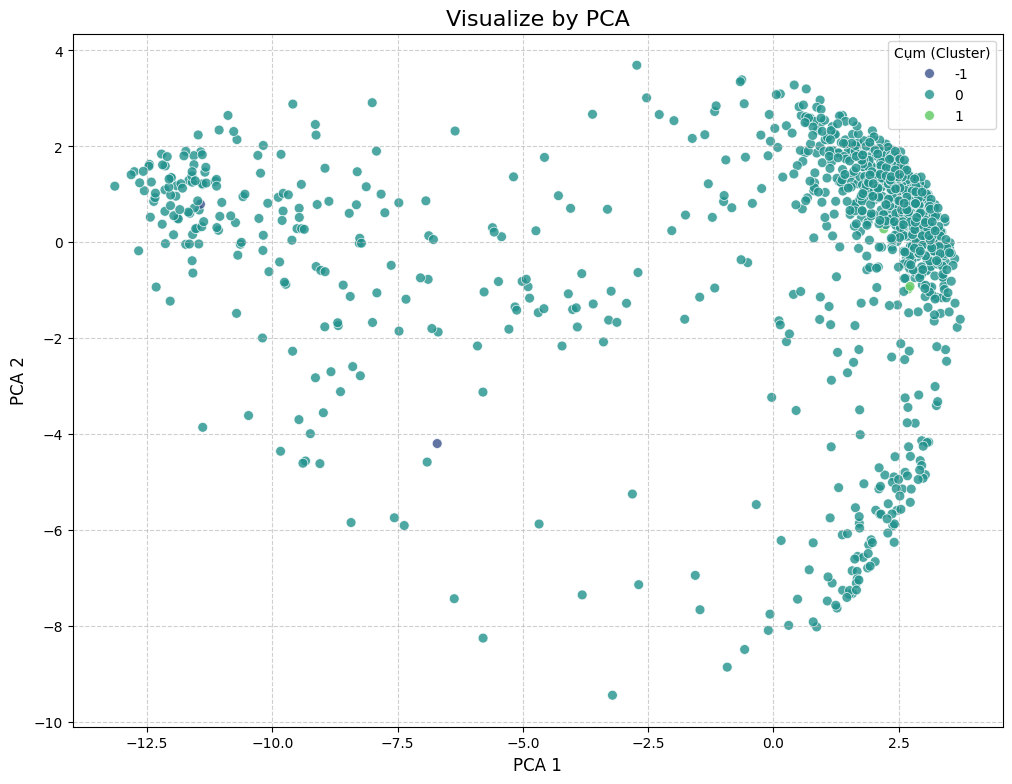

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) ---
# Kiểm tra xem các cột cần thiết có tồn tại không
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    # THAY ĐỔI CHÍNH Ở ĐÂY: Thêm các cột cần loại bỏ vào danh sách
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)

    # Lấy cột 'cluster' làm nhãn
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng PCA trên features (Không thay đổi) ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ (Không thay đổi) ---
    df_pca = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2'])
    df_pca['Cụm (Cluster)'] = labels

    # --- Bước 4: Vẽ biểu đồ Scatter Plot (Không thay đổi) ---
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="PCA 1",
        y="PCA 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_pca,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by PCA', fontsize=16)
    plt.xlabel('PCA 1', fontsize=12)
    plt.ylabel('PCA 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


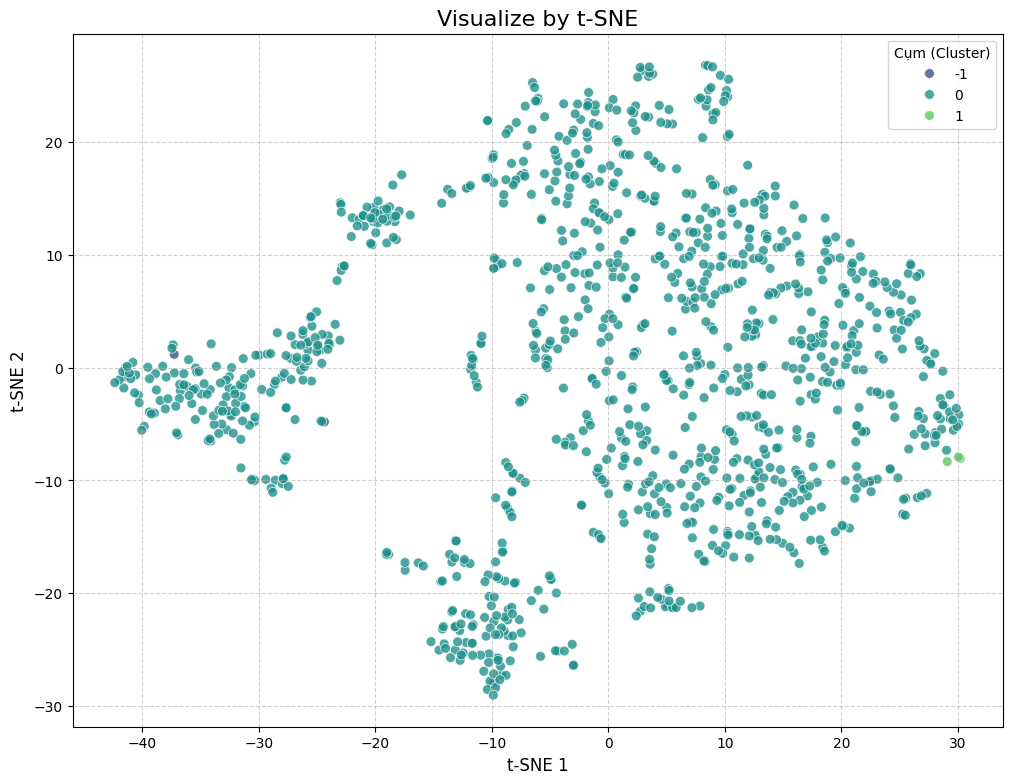

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) (Không thay đổi) ---
# Logic này giống hệt như với PCA
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng t-SNE trên features ---
    # THAY ĐỔI CHÍNH Ở ĐÂY: Sử dụng TSNE thay vì PCA
    # Lưu ý: t-SNE có thể chạy khá chậm trên dữ liệu lớn.
    # 'perplexity' là một tham số quan trọng cần tinh chỉnh.
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
    X_tsne = tsne.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ ---
    # Cập nhật tên cột để phản ánh rằng đây là dữ liệu t-SNE
    df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
    df_tsne['Cụm (Cluster)'] = labels
    # --- Bước 4: Vẽ biểu đồ Scatter Plot ---
    # Cập nhật các trục và tiêu đề cho phù hợp với t-SNE
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="t-SNE 1",
        y="t-SNE 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_tsne,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by t-SNE', fontsize=16)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# TS-Fresh Feature Extractor

In [5]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [6]:
ts_eff = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False, disable_progressbar=True)

In [9]:
X_transform1 = ts_eff.fit_transform(X_reshaped)
X_transform1

,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__fourier_entropy__bins_5,var_0__fourier_entropy__bins_10,var_0__fourier_entropy__bins_100,var_0__permutation_entropy__dimension_3__tau_1,var_0__permutation_entropy__dimension_4__tau_1,var_0__permutation_entropy__dimension_5__tau_1,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,var_0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,8.326673e-15,99.0,0.282349,-0.031322,-0.002650,-0.198324,...,0.481199,0.761938,1.798421,1.486533,2.348272,3.195896,3.914061,4.257520,0.0,2.823046
1,0.0,0.0,0.0,1.0,-2.220446e-16,99.0,0.370024,-0.017788,-0.003766,-0.344959,...,0.575228,1.118198,2.064832,1.458521,2.244796,2.982415,3.745681,4.159734,0.0,2.414896
2,0.0,0.0,0.0,0.0,-2.775558e-15,99.0,0.128092,-0.034196,0.001473,-0.397235,...,0.096509,0.192626,0.773052,1.396873,2.198158,2.999332,3.695983,4.139728,0.0,2.660909
3,0.0,0.0,0.0,0.0,1.110223e-15,99.0,0.415117,-0.040774,0.008324,-0.411602,...,0.509247,0.668811,1.781499,1.197648,1.771670,2.149497,2.482686,2.756530,0.0,2.920940
4,0.0,0.0,0.0,0.0,3.663736e-15,99.0,0.116081,-0.048355,0.004823,-0.494929,...,0.192626,0.192626,0.810494,1.391749,2.147101,2.824659,3.407815,3.878619,0.0,2.604278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0.0,0.0,0.0,0.0,1.332268e-15,99.0,0.096308,-0.047717,0.000365,-0.452917,...,0.192626,0.192626,0.545824,1.336025,2.042741,2.690190,3.236161,3.672530,0.0,3.068717
1130,0.0,0.0,0.0,1.0,7.105427e-15,99.0,0.173610,-0.036302,-0.000315,-0.630160,...,0.192626,0.288342,0.761435,1.474770,2.320502,3.066160,3.802100,4.179141,0.0,2.659794
1131,0.0,0.0,0.0,0.0,4.329870e-15,99.0,0.180034,-0.050054,0.001288,-0.428689,...,0.356468,0.451359,1.102479,1.353975,2.073170,2.680802,3.207523,3.614821,0.0,2.870955
1132,0.0,0.0,0.0,1.0,-1.221245e-15,99.0,0.167555,-0.033351,-0.002839,-0.335559,...,0.288342,0.383650,0.854598,1.443981,2.191501,2.943808,3.546587,3.844293,0.0,3.240705


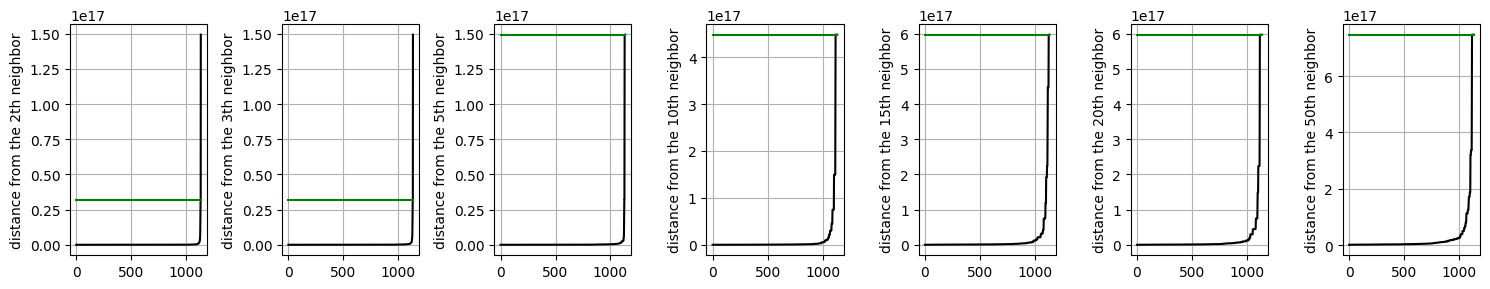

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

ks = [2, 3, 5, 10, 15, 20, 50]
X_eps = []


def eps_choice(df, ks, eps_list):
    dist = squareform(pdist(df, 'euclidean'))

    fig = plt.figure(figsize=(15, 3)) # dimensions of the overall plot
    fig_dims = (1, len(ks))

    for i in range(len(ks)):
        k = ks[i]
        kth_distances = []

        for d in dist:  # d is a vector containing distances between the ith record and all the others
            index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
            kth_distances.append(d[index_kth_distance])  # store the distance in a list

        # Sort the distances
        kth_distances.sort()

        # Create an array of indices
        indices = np.arange(len(kth_distances))

        # Use the KneeLocator to find the elbow point
        knee_locator = KneeLocator(indices, kth_distances, curve='convex', direction='increasing')
        elbow_point = knee_locator.knee
        eps_list.append(round(kth_distances[elbow_point], 2))  # Round to 2 decimal places

        plt.subplot2grid(fig_dims, (0, i))
        plt.plot(indices, kth_distances, 'black')
        plt.plot([0, len(kth_distances)], [kth_distances[elbow_point], kth_distances[elbow_point]], 'g-')  # Plot the elbow point
        plt.ylabel('distance from the {}th neighbor'.format(k))
        plt.grid(True)  # This line adds a grid to the plot

    plt.tight_layout()
    plt.show()

eps_choice(X_transform1, ks, X_eps)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
def dbscan_results(df, eps, ks):
  for i in range(len(eps)):
    db = DBSCAN(eps=eps[i], min_samples=ks[i]).fit(df)
    labels, counts = np.unique(db.labels_, return_counts=True)
    print(labels, counts)
    print(f"eps={eps[i]}, minPts={ks[i]} -> {len(labels)-1} clusters")
    for i in range(len(labels)):
      print(f"Cluster [{labels[i]}]: {counts[i]} samples")

    clustering_labels = db.fit_predict(df)
    #df.loc[:, 'db_labels'] = clustering_labels
    if len(np.unique(db.labels_)) > 2:
        print('Silhouette (F)', silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1]))
    else:
        print('Cannot calculate silhouette score with only one cluster')

    print("--------------------------------")

dbscan_results(df=X_transform1, eps=X_eps, ks=ks)

[-1  0  1  2  3  4  5  6  7] [   2 1081    8    9    6    8    5    8    7]
eps=3.200732179279779e+16, minPts=2 -> 8 clusters
Cluster [-1]: 2 samples
Cluster [0]: 1081 samples
Cluster [1]: 8 samples
Cluster [2]: 9 samples
Cluster [3]: 6 samples
Cluster [4]: 8 samples
Cluster [5]: 5 samples
Cluster [6]: 8 samples
Cluster [7]: 7 samples
Silhouette (F) 0.66932466349799
--------------------------------
[-1  0  1  2  3  4  5  6  7] [   2 1081    8    9    6    8    5    8    7]
eps=3.200732179279779e+16, minPts=3 -> 8 clusters
Cluster [-1]: 2 samples
Cluster [0]: 1081 samples
Cluster [1]: 8 samples
Cluster [2]: 9 samples
Cluster [3]: 6 samples
Cluster [4]: 8 samples
Cluster [5]: 5 samples
Cluster [6]: 8 samples
Cluster [7]: 7 samples
Silhouette (F) 0.66932466349799
--------------------------------
[-1  0  1  2] [   1 1116    9    8]
eps=1.4936750169972346e+17, minPts=5 -> 3 clusters
Cluster [-1]: 1 samples
Cluster [0]: 1116 samples
Cluster [1]: 9 samples
Cluster [2]: 8 samples
Silhouette (F

## Dựa trên kết quả bạn cung cấp, tổ hợp tốt nhất là eps=1.4936750169972346e+17 và minPts=5

In [11]:
from sklearn.cluster import DBSCAN

In [12]:
clusterer = DBSCAN(eps=1.4936750169972346e+17, min_samples=5)

In [13]:
clusterer.fit(X_transform1)

DBSCAN(eps=1.4936750169972346e+17)

In [14]:
df["cluster"] = clusterer.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,0.674897,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,0
1,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,0.073705,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,0
2,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,0.346184,...,-0.818806,-0.813383,-0.794138,-0.777756,-0.800588,-0.827329,8.7,"['Documentary', 'Music']",High,0
3,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,-0.575373,...,-0.555855,-0.611540,-0.612517,-0.613961,-0.615186,-0.616180,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,0
4,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,1.226049,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,0


Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


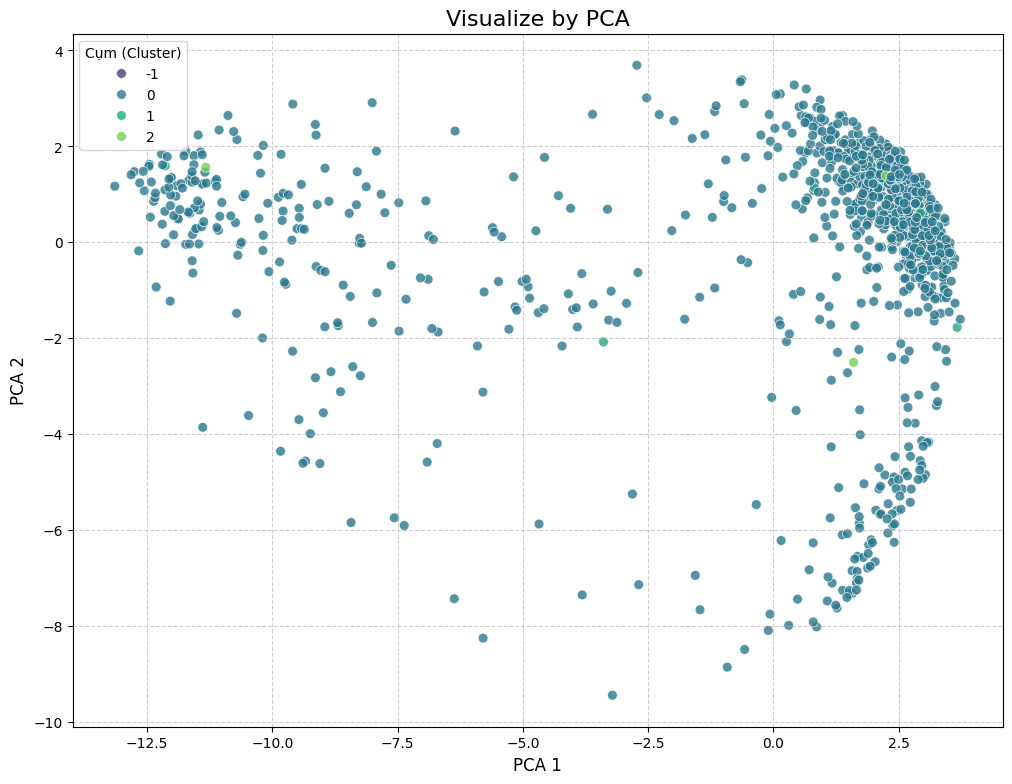

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) ---
# Kiểm tra xem các cột cần thiết có tồn tại không
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    # THAY ĐỔI CHÍNH Ở ĐÂY: Thêm các cột cần loại bỏ vào danh sách
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)

    # Lấy cột 'cluster' làm nhãn
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng PCA trên features (Không thay đổi) ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ (Không thay đổi) ---
    df_pca = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2'])
    df_pca['Cụm (Cluster)'] = labels

    # --- Bước 4: Vẽ biểu đồ Scatter Plot (Không thay đổi) ---
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="PCA 1",
        y="PCA 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_pca,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by PCA', fontsize=16)
    plt.xlabel('PCA 1', fontsize=12)
    plt.ylabel('PCA 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


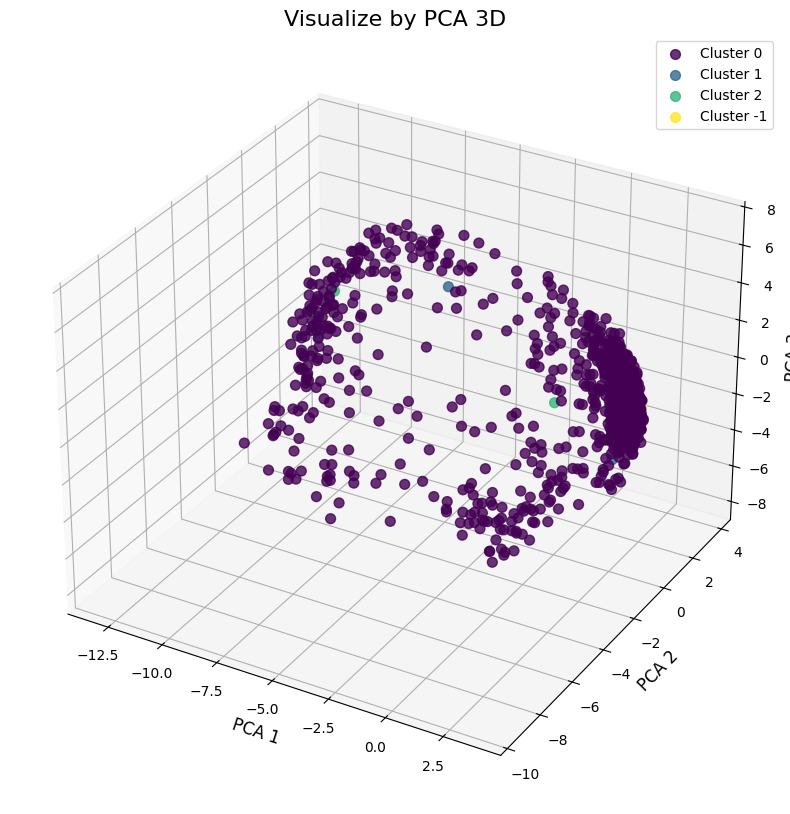

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Thư viện cần thiết cho việc vẽ 3D
from mpl_toolkits.mplot3d import Axes3D

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) ---
# Giả sử 'df' là DataFrame của bạn đã được tải
# Ví dụ: df = pd.read_csv('your_data.csv')

required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng PCA với 3 thành phần ---
    # THAY ĐỔI 1: Thay đổi n_components từ 2 thành 3
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới với 3 cột PCA ---
    # THAY ĐỔI 2: Thêm 'PCA 3' vào danh sách cột
    df_pca = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2', 'PCA 3'])
    df_pca['Cụm (Cluster)'] = labels.values # Dùng .values để tránh lỗi index

    # --- Bước 4: Vẽ biểu đồ Scatter Plot 3D ---
    # THAY ĐỔI 3: Toàn bộ phần vẽ biểu đồ được viết lại cho 3D

    fig = plt.figure(figsize=(13, 10))
    # Tạo một subplot 3D
    ax = fig.add_subplot(111, projection='3d')

    # Lấy danh sách các cụm và màu sắc tương ứng
    clusters = df_pca['Cụm (Cluster)'].unique()
    # Tạo bảng màu
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

    # Vẽ từng cụm với một màu khác nhau để tạo legend
    for i, cluster in enumerate(clusters):
        # Lọc ra các điểm dữ liệu thuộc về cụm hiện tại
        cluster_data = df_pca[df_pca['Cụm (Cluster)'] == cluster]

        ax.scatter(
            xs=cluster_data['PCA 1'],
            ys=cluster_data['PCA 2'],
            zs=cluster_data['PCA 3'],
            c=[colors[i]], # Màu sắc cho cụm này
            label=f'Cluster {cluster}', # Nhãn cho legend
            s=50, # Kích thước điểm
            alpha=0.8
        )

    # Thiết lập tiêu đề và nhãn cho các trục
    ax.set_title('Visualize by PCA 3D', fontsize=16)
    ax.set_xlabel('PCA 1', fontsize=12)
    ax.set_ylabel('PCA 2', fontsize=12)
    ax.set_zlabel('PCA 3', fontsize=12)

    # Hiển thị legend
    ax.legend()

    # Hiển thị lưới
    ax.grid(True)

    plt.show()

Các cột được sử dụng làm features:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


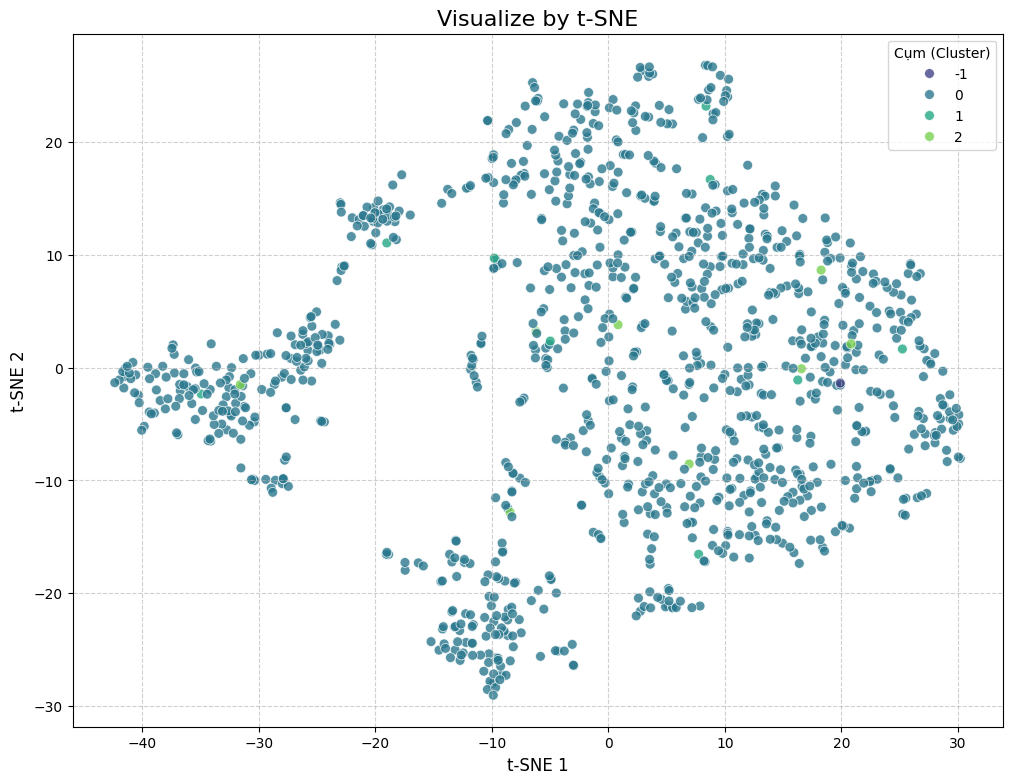

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Bước 1: Tách dữ liệu (features) và nhãn (labels) (Không thay đổi) ---
# Logic này giống hệt như với PCA
required_cols = ['cluster', 'rating', 'genre', 'rating_category']
if not all(col in df.columns for col in required_cols):
    print(f"Lỗi: DataFrame của bạn thiếu một trong các cột sau: {required_cols}")
else:
    columns_to_drop = ['cluster', 'rating', 'genre', 'rating_category']
    features = df.drop(columns=columns_to_drop)
    labels = df['cluster']

    print("Các cột được sử dụng làm features:")
    print(features.columns.tolist())

    # --- Bước 2: Áp dụng t-SNE trên features ---
    # THAY ĐỔI CHÍNH Ở ĐÂY: Sử dụng TSNE thay vì PCA
    # Lưu ý: t-SNE có thể chạy khá chậm trên dữ liệu lớn.
    # 'perplexity' là một tham số quan trọng cần tinh chỉnh.
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
    X_tsne = tsne.fit_transform(features)

    # --- Bước 3: Tạo DataFrame mới để vẽ biểu đồ ---
    # Cập nhật tên cột để phản ánh rằng đây là dữ liệu t-SNE
    df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
    df_tsne['Cụm (Cluster)'] = labels
    # --- Bước 4: Vẽ biểu đồ Scatter Plot ---
    # Cập nhật các trục và tiêu đề cho phù hợp với t-SNE
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        x="t-SNE 1",
        y="t-SNE 2",
        hue="Cụm (Cluster)",
        palette=sns.color_palette("viridis", n_colors=labels.nunique()),
        data=df_tsne,
        legend="full",
        alpha=0.8,
        s=50
    )

    plt.title('Visualize by t-SNE', fontsize=16)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()